In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [3]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.isnull().sum().sort_values(ascending=False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

In [4]:
print(train_data.shape)
print(test_data.shape)

(891, 12)
(418, 11)


In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [7]:
train_data['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [8]:
train_data[['Sex', 'Survived']].groupby('Sex', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Female survival rate is higher generally

In [9]:
train_data['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [10]:
train_data[['Pclass', 'Survived']].groupby('Pclass', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Pclass 1 has the highest survival rate generally

In [11]:
train_data['Embarked'].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [12]:
train_data[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Those who embarked from city C has highest survival rate genrally

In [13]:
from collections import Counter 

def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, val in outlier_indices.items() if val > n)
    return multiple_outliers
    
outliers_to_drop = detect_outliers(train_data, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print(outliers_to_drop)
print("These {} indices will be dropped".format(len(outliers_to_drop)),outliers_to_drop)

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]
These 10 indices will be dropped [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [14]:
train_data.loc[outliers_to_drop, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [15]:
print("Before: {} rows".format(len(train_data)))
train_data = train_data.drop(outliers_to_drop, axis = 0).reset_index(drop=True)
print("After: {} rows".format(len(train_data)))

Before: 891 rows
After: 881 rows


<Axes: >

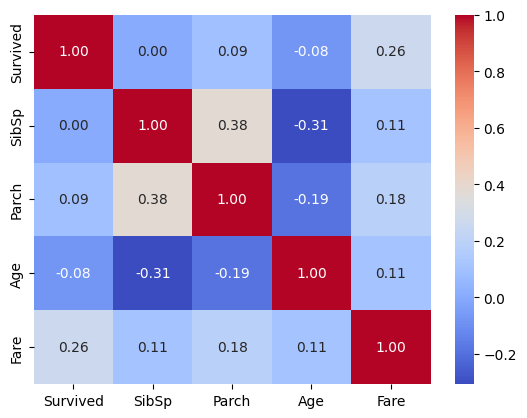

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(train_data[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

fare seems to have hight correlation with survival rate which makes sense as fare is related to pclass

In [17]:
train_data['SibSp'].value_counts()

SibSp
0    608
1    209
2     28
4     18
3     13
5      5
Name: count, dtype: int64

In [18]:
train_data[['SibSp', 'Survived']].groupby('SibSp', as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


In [19]:
train_data['Parch'].value_counts()

Parch
0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [20]:
train_data[['Parch', 'Survived']].groupby('Parch', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


# **Data Preprocessing**

In [21]:
train_data = train_data.drop(['Ticket', 'Cabin'], axis = 1)
test_data = test_data.drop(['Ticket', 'Cabin'], axis = 1)

**Age and Embarked are the cols with missing values in the train data**

In [22]:
#Calculate the mode for Embarked

mode = train_data['Embarked'].dropna().mode()[0]
mode

'S'

In [23]:
#Replace the missing Embarked values with mode value

train_data['Embarked'].fillna(mode, inplace=True)

/tmp/ipykernel_33/1156089120.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Embarked'].fillna(mode, inplace=True)


In [24]:
train_data['Embarked'].isnull().sum()

0

**Age and Fare are the cols with missing values in the train data**

In [25]:
#Calculate the median for Fare

median = test_data['Fare'].dropna().median()
median

14.4542

In [26]:
#Replace the missing Fare values with median value

test_data['Fare'].fillna(median, inplace=True)

/tmp/ipykernel_33/869814548.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Fare'].fillna(median, inplace=True)


In [27]:
test_data['Fare'].isnull().sum()

0

In [28]:
combine = pd.concat([train_data, test_data], axis = 0).reset_index(drop=True)
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [29]:
combine.isnull().sum().sort_values(ascending=False)

Survived       418
Age            256
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

The survived missing values are from test data set, ignore it. Fill mising values in Age column.

**Convert sex values into numerical values 0 and 1**

In [30]:
combine['Sex'] = combine['Sex'].map({'male': 0, 'female': 1})

**Find the features that are more correlated with age to predict the missing values for age**

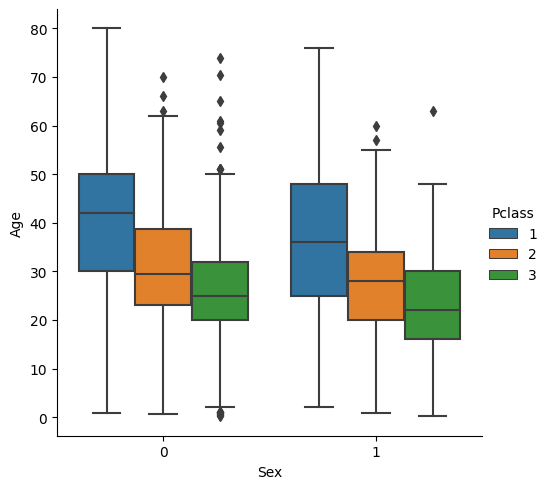

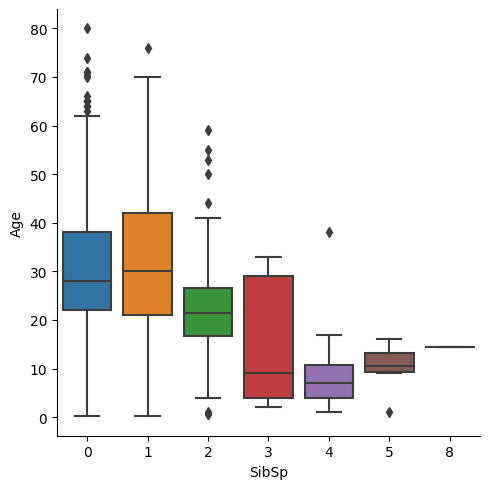

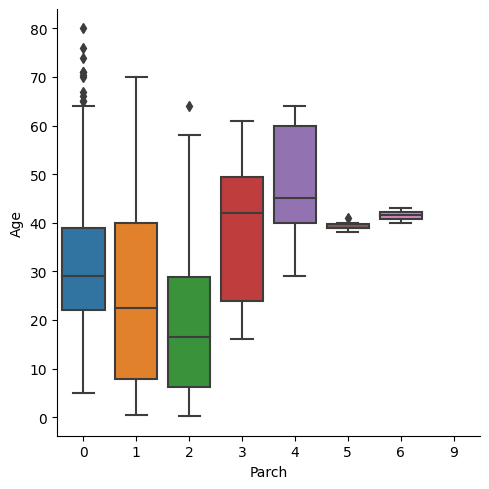

In [31]:
sns.catplot(x='Sex', y='Age', hue='Pclass', kind='box', data=combine)
sns.catplot(x='SibSp', y='Age', kind='box', data=combine)
sns.catplot(x='Parch', y='Age', kind='box', data=combine)

<Axes: >

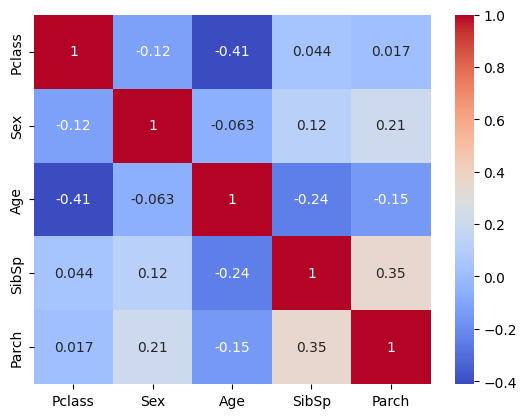

In [32]:
sns.heatmap(combine.drop(['Survived', 'Name', 'PassengerId', 'Fare', 'Embarked'], axis = 1).corr(), annot = True, cmap='coolwarm')

Age is not correlated with sex but negatively correlated with Pclass, SibSp and Parch

**Fill in missing values for Age**

In [33]:
age_nan_indices = list(combine[combine['Age'].isnull()].index)
len(age_nan_indices)

256

In [34]:
# Loop through the list and impute missing values

for index in age_nan_indices:
    median_age = combine['Age'].median()
    predict_age = combine['Age'][(combine['SibSp'] == combine.iloc[index]['SibSp'])
                                &(combine['Parch'] == combine.iloc[index]['Parch'])
                                &(combine['Pclass'] == combine.iloc[index]['Pclass'])].median()
    
    if np.isnan(predict_age):
        combine['Age'].iloc[index] = median_age
    else:
        combine['Age'].iloc[index] = predict_age

/tmp/ipykernel_33/3658998838.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  combine['Age'].iloc[index] = predict_age
/tmp/ipykernel_33/3658998838.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [35]:
combine["Age"].isnull().sum()

0

# **Data Transformation**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Passenger fare distribution')

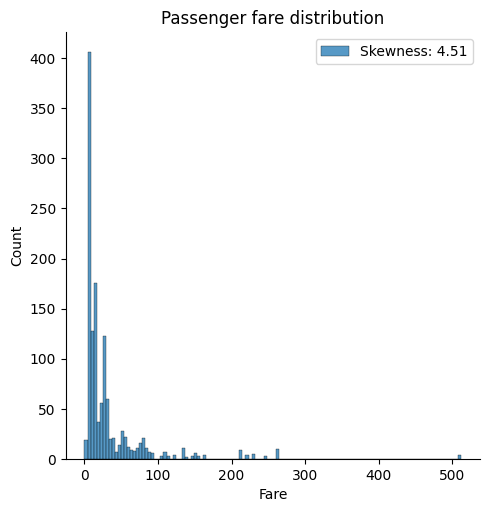

In [36]:
# Passenger fare distribution

sns.displot(combine['Fare'], label='Skewness: %.2f'% combine['Fare'].skew())
plt.legend(loc = 'best')
plt.title('Passenger fare distribution')

In [37]:
# Apply log transformation to fare column to reduce skewness

combine["Fare"] = combine["Fare"].map(lambda x: np.log(x) if x > 0 else 0)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Passenger fare distribution after log transformation')

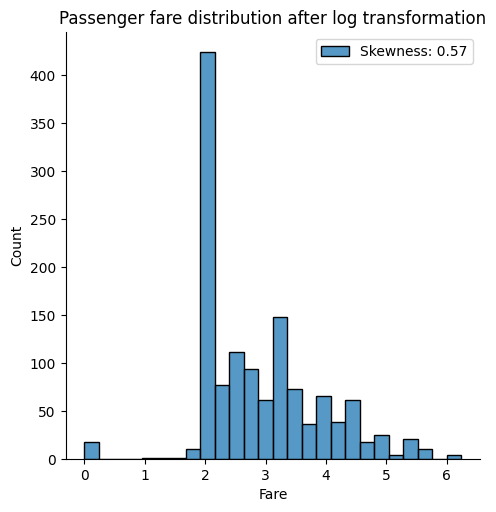

In [38]:
# Passenger fare distribution after log transformation

sns.displot(combine['Fare'], label='Skewness: %.2f'% combine['Fare'].skew())
plt.legend(loc = 'best')
plt.title('Passenger fare distribution after log transformation')

# **Feature Engineering**

3 new features for better accuracy

1. Title 
2. isAlone
3. Age*Class

**Title**

In [39]:
# Add Title

combine['Title'] = [name.split(',')[1].split('.')[0].strip() for name in combine['Name']]
combine[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [40]:
combine['Title'].value_counts()

Title
Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [41]:
combine['Title'] = combine['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Jonkheer', 'Don', 'Capt', 'the Countess', 'Sir', 'Dona'], 'Rare')
combine['Title'] = combine['Title'].replace(['Mlle', 'Ms'], 'Miss')
combine['Title'] = combine['Title'].replace('Mme', 'Mrs')

In [42]:
combine['Title'].value_counts()

Title
Mr        753
Miss      259
Mrs       198
Master     60
Rare       29
Name: count, dtype: int64

In [43]:
# Mean of survival by title
combine[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.711111
0,Master,0.589744
4,Rare,0.347826
2,Mr,0.157895


In [44]:
# Drop name column

combine = combine.drop('Name', axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,3,0,22.0,1,0,1.981001,S,Mr
1,2,1.0,1,1,38.0,1,0,4.266662,C,Mrs
2,3,1.0,3,1,26.0,0,0,2.070022,S,Miss
3,4,1.0,1,1,35.0,1,0,3.972177,S,Mrs
4,5,0.0,3,0,35.0,0,0,2.085672,S,Mr


**isAlone**

In [45]:
combine['FamilySize'] = combine['SibSp'] + combine['Parch'] + 1
combine[['SibSp', 'Parch', 'FamilySize']].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


In [46]:
# Mean of survival by title
combine[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.052632
7,8,0.000000
8,11,NaN


In [47]:
# Add isAlone feature

combine['IsAlone'] = 0
combine.loc[combine['FamilySize'] == 1, 'IsAlone'] = 1


In [48]:
# Mean of survival by IsAlone

combine[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,IsAlone,Survived
0,0,0.514535
1,1,0.303538


In [49]:
# drop SibSp, Parch, FamilySize columns

combine = combine.drop(['SibSp', 'Parch', 'FamilySize'], axis = 1)
combine.head(10)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,1,0.0,3,0,22.0,1.981001,S,Mr,0
1,2,1.0,1,1,38.0,4.266662,C,Mrs,0
2,3,1.0,3,1,26.0,2.070022,S,Miss,1
3,4,1.0,1,1,35.0,3.972177,S,Mrs,0
4,5,0.0,3,0,35.0,2.085672,S,Mr,1
5,6,0.0,3,0,25.0,2.135148,Q,Mr,1
6,7,0.0,1,0,54.0,3.948596,S,Mr,1
7,8,0.0,3,0,2.0,3.048088,S,Master,0
8,9,1.0,3,1,27.0,2.409941,S,Mrs,0
9,10,1.0,2,1,14.0,3.403555,C,Mrs,0


**Age*Class**

Create 5 seperate age bands and calculate the mean survival for each age band

In [50]:
combine['AgeBand'] = pd.cut(combine['Age'], 5)
combine[['AgeBand', 'Survived']].groupby('AgeBand', as_index=False).mean().sort_values(by='Survived', ascending=False)

/tmp/ipykernel_33/2798267335.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combine[['AgeBand', 'Survived']].groupby('AgeBand', as_index=False).mean().sort_values(by='Survived', ascending=False)


,AgeBand,Survived
0,"(0.0902, 16.136]",0.532110
3,"(48.068, 64.034]",0.434783
2,"(32.102, 48.068]",0.412844
1,"(16.136, 32.102]",0.339662
4,"(64.034, 80.0]",0.090909


In [51]:
combine.loc[combine['Age'] <= 16.136, 'Age'] = 0
combine.loc[(combine['Age'] > 16.136) & (combine['Age'] <= 32.102), 'Age'] = 1
combine.loc[(combine['Age'] > 32.102) & (combine['Age'] <= 48.068), 'Age'] = 2
combine.loc[(combine['Age'] > 48.068) & (combine['Age'] <= 64.034), 'Age'] = 3
combine.loc[combine['Age'] > 64.034, 'Age'] = 4

In [52]:
# Drop AgeBand column
combine = combine.drop('AgeBand', axis = 1)

In [53]:
combine[['Age', 'Pclass']].dtypes

Age       float64
Pclass      int64
dtype: object

In [54]:
combine['Age'] = combine['Age'].astype('int')
combine['Age'].dtype

dtype('int64')

In [55]:
# Create Age*Class feature

combine['Age*Class'] = combine['Age'] * combine['Pclass']
combine[['Age', 'Pclass', 'Age*Class']].head()

,Age,Pclass,Age*Class
0,1,3,3
1,2,1,2
2,1,3,3
3,2,1,2
4,2,3,6


# **Feature Encoding**

It will be convenient if all the inputs to the ML model are numerical

Encode the Title and Embarked features into numerical data and transform Fare into an oridnal variable instead of continuous variable. 

In [56]:
combine = pd.get_dummies(combine, columns = ['Title'])
combine = pd.get_dummies(combine, columns = ['Embarked'], prefix = 'Em')
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1.981001,0,3,False,False,True,False,False,False,False,True
1,2,1.0,1,1,2,4.266662,0,2,False,False,False,True,False,True,False,False
2,3,1.0,3,1,1,2.070022,1,3,False,True,False,False,False,False,False,True
3,4,1.0,1,1,2,3.972177,0,2,False,False,False,True,False,False,False,True
4,5,0.0,3,0,2,2.085672,1,6,False,False,True,False,False,False,False,True


In [57]:
combine.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Sex               0
Age               0
Fare              0
IsAlone           0
Age*Class         0
Title_Master      0
Title_Miss        0
Title_Mr          0
Title_Mrs         0
Title_Rare        0
Em_C              0
Em_Q              0
Em_S              0
dtype: int64

In [58]:
combine = combine.replace({True: 1, False: 0})
combine.head()

/tmp/ipykernel_33/399824675.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combine = combine.replace({True: 1, False: 0})


,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1.981001,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,4.266662,0,2,0,0,0,1,0,1,0,0
2,3,1.0,3,1,1,2.070022,1,3,0,1,0,0,0,0,0,1
3,4,1.0,1,1,2,3.972177,0,2,0,0,0,1,0,0,0,1
4,5,0.0,3,0,2,2.085672,1,6,0,0,1,0,0,0,0,1


**Divide Fare into 4 bands**

In [59]:
combine['FareBand'] = pd.cut(combine['Fare'], 4)
combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand')

/tmp/ipykernel_33/1080770379.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand')


,FareBand,Survived
0,"(-0.00624, 1.56]",0.062500
1,"(1.56, 3.119]",0.288719
2,"(3.119, 4.679]",0.517007
3,"(4.679, 6.239]",0.750000


In [60]:
# Assign ordinal to each fare band

combine.loc[combine['Fare'] <= 1.56, 'Fare'] = 0
combine.loc[(combine['Fare'] > 1.56) & (combine['Fare'] <= 3.119), 'Fare'] = 1
combine.loc[(combine['Fare'] > 3.119) & (combine['Fare'] <= 4.679), 'Fare'] = 2
combine.loc[combine['Fare'] > 4.679, 'Fare'] = 3

In [61]:
# convert the data type of Fare to int
combine['Fare'] = combine['Fare'].astype('int')

In [62]:
# Drop FareBand feature
combine = combine.drop('FareBand', axis = 1)

In [63]:
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,3,1.0,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,4,1.0,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,5,0.0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [64]:
# split train and test from combine

train = combine[:len(train_data)]
test = combine[len(train_data):]

In [65]:
train.shape

(881, 16)

In [66]:
test.shape

(418, 16)

In [67]:
# Drop PassengerId col

train = train.drop('PassengerId', axis = 1)
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,0.0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,1.0,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,1.0,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,1.0,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,0.0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [68]:
train['Survived'] = train['Survived'].astype('int')
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,1,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,1,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,1,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [69]:
test = test.drop('Survived', axis = 1)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
881,892,3,0,2,1,1,6,0,0,1,0,0,0,1,0
882,893,3,1,2,1,0,6,0,0,0,1,0,0,0,1
883,894,2,0,3,1,1,6,0,0,1,0,0,0,1,0
884,895,3,0,1,1,1,3,0,0,1,0,0,0,0,1
885,896,3,1,1,1,0,3,0,0,0,1,0,0,0,1


# **Modelling**

**Split training data**

In [70]:
X_train = train.drop('Survived', axis = 1)
Y_train = train["Survived"]
X_test = test.drop('PassengerId', axis = 1).copy()
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (881, 14)
Y_train shape:  (881,)
X_test shape:  (418, 14)


**Fit model to data and make predictions**

**1. Logistic Regression**

In [71]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.93

**2. Support Vector Machines**

In [72]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.09

**3. K-nearest neighbours**

In [73]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.56

**4. Guassian Naive Bayes**

In [74]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, Y_train)
Y_pred = gnb.predict(X_test)
acc_gnb = round(gnb.score(X_train, Y_train) * 100, 2)
acc_gnb

79.11

**5. Perceptron**

In [75]:
from sklearn.linear_model import Perceptron

per = Perceptron()
per.fit(X_train, Y_train)
Y_pred = per.predict(X_test)
acc_per = round(per.score(X_train, Y_train) * 100, 2)
acc_per

79.57

**6. Linear SVC**

In [76]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


80.25

**7. Stochastic Gradient Descent**

In [77]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

77.3

**8. Decision Tree**

In [78]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

85.7

**9. Random Forest**

In [79]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

85.7

**10. CatBoost**

In [80]:
from catboost import CatBoostClassifier

cat_boost = CatBoostClassifier()
cat_boost.fit(X_train, Y_train)
Y_pred = cat_boost.predict(X_test)
acc_cat_boost = round(cat_boost.score(X_train, Y_train) * 100, 2)
acc_cat_boost

Learning rate set to 0.00976
0:	learn: 0.6868136	total: 56.5ms	remaining: 56.5s
1:	learn: 0.6798485	total: 57.8ms	remaining: 28.9s
2:	learn: 0.6729520	total: 59.1ms	remaining: 19.6s
3:	learn: 0.6669729	total: 62ms	remaining: 15.4s
4:	learn: 0.6607853	total: 63.5ms	remaining: 12.6s
5:	learn: 0.6554568	total: 68.4ms	remaining: 11.3s
6:	learn: 0.6500727	total: 70.5ms	remaining: 10s
7:	learn: 0.6437982	total: 74.5ms	remaining: 9.23s
8:	learn: 0.6398272	total: 75.5ms	remaining: 8.31s
9:	learn: 0.6351628	total: 76.6ms	remaining: 7.59s
10:	learn: 0.6305969	total: 77.6ms	remaining: 6.97s
11:	learn: 0.6252274	total: 78.6ms	remaining: 6.47s
12:	learn: 0.6203165	total: 79.7ms	remaining: 6.05s
13:	learn: 0.6163249	total: 80.6ms	remaining: 5.67s
14:	learn: 0.6126752	total: 81.3ms	remaining: 5.34s
15:	learn: 0.6078515	total: 82.4ms	remaining: 5.07s
16:	learn: 0.6033553	total: 83.5ms	remaining: 4.83s
17:	learn: 0.5984437	total: 84.4ms	remaining: 4.61s
18:	learn: 0.5935188	total: 85.8ms	remaining: 4.4

85.7

# **Model evaluation and hyperparameter tuning**

**Training accuracy**

In [81]:
models = pd.DataFrame({'Model': ['Logistic Regression', 'SVM', 'KNN', 'Guassian Naive Bayes', 'Perceptron', 'Linear SVC', 'SGD', 'Decision Tree', 'Random Forest', 'CatBoost'],
                      'Score': [acc_log, acc_svc, acc_knn, acc_gnb, acc_per, acc_linear_svc, acc_sgd, acc_decision_tree, acc_random_forest, acc_cat_boost]})
models.sort_values(by='Score',ascending=False, ignore_index=True)

,Model,Score
0,Decision Tree,85.70
1,Random Forest,85.70
2,CatBoost,85.70
3,KNN,84.56
4,SVM,83.09
5,Logistic Regression,80.93
6,Linear SVC,80.25
7,Perceptron,79.57
8,Guassian Naive Bayes,79.11
9,SGD,77.30


**Cross Validation**

In [82]:
classifiers = []

classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

10

In [83]:
# List which contains cross validation result for aech classifier
from sklearn.model_selection import cross_val_score

cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring = 'accuracy', cv = 10))

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Learning rate set to 0.009326
0:	learn: 0.6870154	total: 1.08ms	remaining: 1.08s
1:	learn: 0.6803102	total: 1.93ms	remaining: 962ms
2:	learn: 0.6743326	total: 2.69ms	remaining: 894ms
3:	learn: 0.6684760	total: 3.39ms	remaining: 845ms
4:	learn: 0.6624557	total: 4.11ms	remaining: 818ms
5:	learn: 0.6573314	total: 4.8ms	remaining: 796ms
6:	learn: 0.6520748	total: 5.5ms	remaining: 780ms
7:	learn: 0.6460856	total: 6.25ms	remaining: 775ms
8:	learn: 0.6422711	total: 6.8ms	remaining: 749ms
9:	learn: 0.6376840	total: 7.47ms	remaining: 740ms
10:	learn: 0.6326541	total: 8.47ms	remaining: 762ms
11:	learn: 0.6272334	total: 9.17ms	remaining: 755ms
12:	learn: 0.6224744	total: 9.77ms	remaining: 742ms
13:	learn: 0.6175199	total: 10.4ms	remaining: 736ms
14:	learn: 0.6124417	total: 11.2ms	remaining: 733ms
15:	learn: 0.6097890	total: 11.6ms	remaining: 715ms
16:	learn: 0.6050558	total: 12.4ms	remaining: 716ms
17:	learn: 0.6004952	total: 13ms	remaining: 712ms
18:	learn: 0.5958639	total: 13.8ms	remaining: 710

In [84]:
cv_mean = []
cv_std = []

for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [85]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std, 'Algorithm': ['Logistic Regression', 'SVM', 'KNN', 'Guassian Naive Bayes', 'Perceptron', 'Linear SVC', 'SGD', 'Decision Tree', 'Random Forest', 'CatBoost']})
cv_res.sort_values(by='Cross Validation Mean', ascending=False, ignore_index=True)

,Cross Validation Mean,Cross Validation Std,Algorithm
0,0.821782,0.042574,SVM
1,0.817275,0.035240,KNN
2,0.815028,0.036378,CatBoost
3,0.804801,0.029279,Logistic Regression
4,0.803677,0.030997,Random Forest
5,0.800243,0.033294,Linear SVC
6,0.788904,0.025236,Decision Tree
7,0.783223,0.041915,Guassian Naive Bayes
8,0.733287,0.043881,Perceptron
9,0.732010,0.122776,SGD


SVM has the highest cross validation mean score

**Hyperparameter tuning for SVM**

In [86]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000],
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.757 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.778 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.716 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.814 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.818 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.784 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.761 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.718 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [88]:
print("Best parameters:", grid.best_params_)
print("Best estimators:", grid.best_estimator_)

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimators: SVC(C=100, gamma=0.01)


In [89]:
# Training accuracy

svc = SVC(C = 100, gamma = 0.01, kernel = 'rbf')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.54

In [90]:
# Mean cross validation score

cross_val_score(svc, X_train, Y_train, scoring = 'accuracy', cv = 10).mean()

0.8297242083758938

Mean Cross validation score increased slightly

In [91]:
Y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [97]:
submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
submit.head()

,PassengerId,Survived
881,892,0
882,893,0
883,894,0
884,895,0
885,896,1


In [94]:
submit.shape

(418, 2)

In [98]:
submit.to_csv('submission.csv', index = False)